In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from tqdm import tqdm
import matplotlib

In [2]:
with open('genre_dictionary.pkl', 'rb') as f:
    genre_dict = pickle.load(f)

In [3]:
retrieval_path = './retrieved_ids/'
files = []
for file in os.listdir(retrieval_path):
    if file.endswith(".pkl"):
        files.append(file)
    
print(files)

['id_lyrics_tfidf_inner_product_retrieved_ids.pkl', 'baseline_retrieved_ids.pkl', 'id_lyrics_word2vec_inner_product_retrieved_ids.pkl', 'id_bert_inner_product_retrieved_ids.pkl', 'id_lyrics_tfidf_cosine_retrieved_ids.pkl', 'mfcc_bow_cosine_retrieved_ids.pkl', 'mfcc_bow_inner_product_retrieved_ids.pkl', 'cosine_retrieved_ids.pkl', 'id_bert_cosine_retrieved_ids.pkl', 'essentia_inner_product_retrieved_ids.pkl', 'resnet_cosine_retrieved_ids.pkl', 'resnet_inner_product_retrieved_ids.pkl', 'vgg19_inner_product_retrieved_ids.pkl', 'inner_product_retrieved_ids.pkl', 'vgg19_cosine_retrieved_ids.pkl', 'id_lyrics_word2vec_cosine_retrieved_ids.pkl', 'essentia_cosine_retrieved_ids.pkl']


In [6]:
positive_rate = {}
for idx in tqdm(genre_dict):
    p = 0
    for idy in genre_dict:
        if func(genre_dict[idx], genre_dict[idy]):
            p += 1
    positive_rate[idx] = p
with open(f'positive_rate.pkl', 'wb') as f:
    pickle.dump(positive_rate, f)

100%|█████████████████████████████████████| 68641/68641 [44:34<00:00, 25.67it/s]


In [5]:
def func(a, b):
    return not set(a).isdisjoint(b)

def precision(song_id: str, k: int, retrieved_dict: dict, genre_dict: dict):
    top_k_ids = retrieved_dict[song_id][:k]
    query_genre = genre_dict[song_id]
    # print(query_genre)
    tp = 0
    prec_list = []
    for idx, ids in enumerate(top_k_ids):
        genres = genre_dict[ids]
        # print(genres)
        if any(item in query_genre for item in genres):
            tp += 1
        prec = tp / (idx+1)
        prec_list.append(prec)
    return np.array(prec_list)

def recall(song_id: str, k: int, retrieved_dict: dict, genre_dict: dict, positive_rate: dict):
    top_k_ids = retrieved_dict[song_id][:k]
    query_genre = genre_dict[song_id]
    # print(query_genre)
    rec_list = []
    tp = 0
    p = positive_rate[song_id]
    for idx in top_k_ids:
        genres = genre_dict[idx]
        # print(genres)
        if any(item in query_genre for item in genres):
            tp += 1
        recall = tp / p
        rec_list.append(recall)
    return np.array(rec_list)

def precision_recall(retrieval_path: str, k: int=100):
    with open(retrieval_path, 'rb') as f:
        retrieved_dict = pickle.load(f)
    with open('genre_dictionary.pkl', 'rb') as f:
        genre_dict = pickle.load(f)
    with open(f'positive_rate.pkl', 'rb') as f:
        positive_rate = pickle.load(f)
    prec_list = np.zeros(k)
    recall_list = np.zeros(k)
    for song_id in retrieved_dict:
        prec_list = prec_list + precision(song_id, k, retrieved_dict, genre_dict)
        recall_list = recall_list + recall(song_id, k, retrieved_dict, genre_dict, positive_rate)
    prec_list = prec_list/len(retrieved_dict)
    recall_list = recall_list/len(retrieved_dict)
    return prec_list, recall_list

In [8]:
p_dict = {}
r_dict = {}
for file in tqdm(files):
    precis, reca = precision_recall(retrieval_path+file, 100)
    p_dict[file] = precis
    r_dict[file] = reca

100%|███████████████████████████████████████████| 17/17 [04:04<00:00, 14.36s/it]


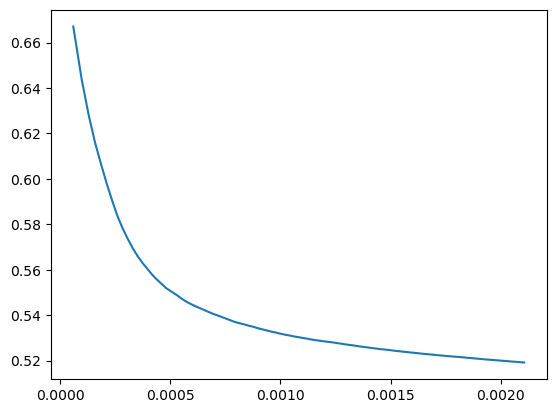

In [8]:
plt.plot(reca, precis)
plt.show()

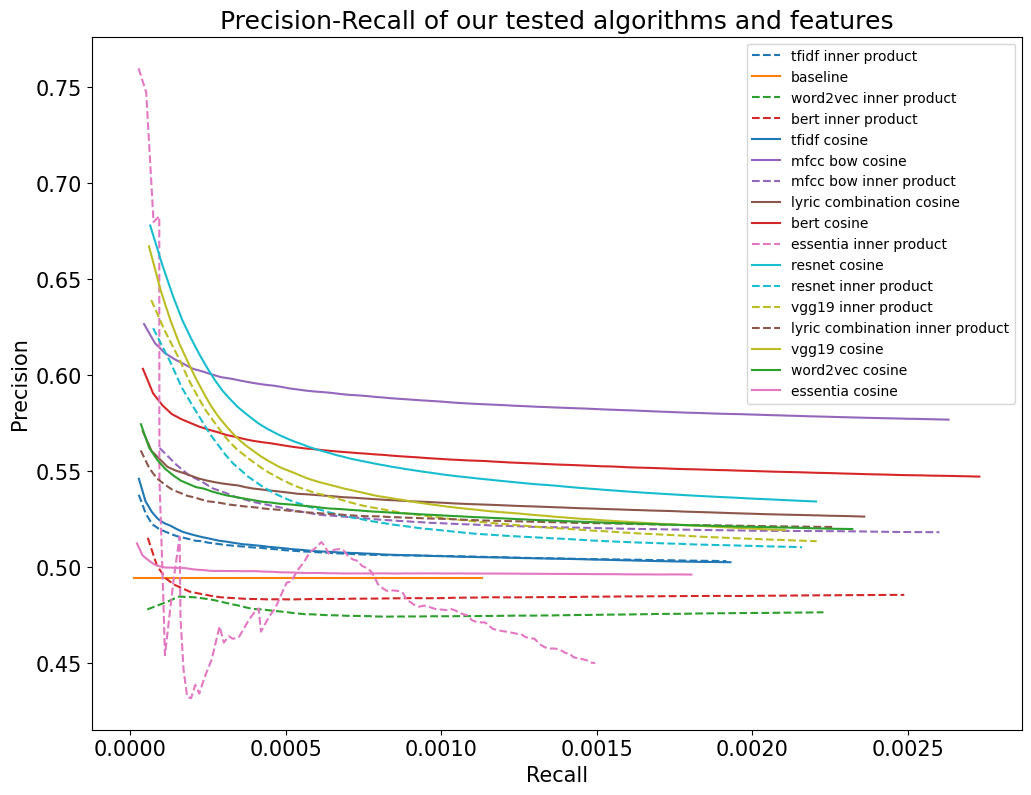

In [25]:
#labels = ['baseline', 'lyrics cosine', 'lyrics inner product', 'essentia cosine', 'essentia inner product', 
#          'mfcc bow cosine', 'mfcc bow inner product','resnet cosine', 'resnet inner product', 'vgg19 cosine',
#          'vgg19 inner product ']
matplotlib.rcParams.update({'font.size': 15})
labels = ['tfidf inner product', 'baseline', 'word2vec inner product', 'bert inner product', 'tfidf cosine', 
          'mfcc bow cosine', 'mfcc bow inner product', 'lyric combination cosine', 'bert cosine', 
          'essentia inner product', 'resnet cosine', 'resnet inner product', 'vgg19 inner product', 
          'lyric combination inner product', 'vgg19 cosine', 'word2vec cosine', 'essentia cosine']
plt.figure(figsize=(12,9))
for idx, file in enumerate(files):
    plt.plot(r_dict[file], p_dict[file], label=labels[idx], c = color_dict[labels[idx]][0], linestyle = color_dict[labels[idx]][1])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall of our tested algorithms and features')
plt.legend(fontsize = 10)
plt.savefig('prec_recall_plot.png')
plt.show()

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [14]:
color_dict = {'tfidf inner product':['#1f77b4', '--'], 'baseline':['#ff7f0e','-'], 
              'word2vec inner product':['#2ca02c', '--'],'bert inner product':['#d62728', '--'], 
              'tfidf cosine':['#1f77b4', '-'], 'mfcc bow cosine':['#9467bd', '-'], 
              'mfcc bow inner product':['#9467bd', '--'], 'lyric combination cosine':['#8c564b', '-'], 
              'bert cosine':['#d62728', '-'], 'essentia inner product':['#e377c2', '--'], 
              'resnet cosine':['#17becf', '-'], 'resnet inner product':['#17becf', '--'], 
              'vgg19 inner product':['#bcbd22', '--'], 'lyric combination inner product':['#8c564b', '--'], 
              'vgg19 cosine':['#bcbd22', '-'], 'word2vec cosine':['#2ca02c', '-'], 
              'essentia cosine':['#e377c2', '-']}